# Classification of normal urine and Paraquat poisoned cases (Simulation)

## Install required python modules

In [4]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


In [ ]:
%%bash
pip install -r ../requirements.txt

# Default setting (4 metabolites changed)

"Creatinine"	0.18	0.07
"Citric acid"	0.04	0.04
"L-Lactic acid"	14.24	14.24
"L-Alanine"	5.28	5.28

## Import data

In [24]:
import numpy as np

filename_control = '../data/Simulation/Default_setting/Spectra_Mixt1.txt'
filename_case = '../data/Simulation/Default_setting/Spectra_Mix2.txt'
data_control = np.loadtxt(filename_control, dtype=float)
data_case = np.loadtxt(filename_case, dtype=float)

In [31]:
#Convert into dataframes
import pandas as pd

df_control = pd.DataFrame(data_control).T
df_case = pd.DataFrame(data_case).T

#Concatenate control and case df
df_NMR_intensities = pd.concat([df_control, df_case])
df_status = [0] * df_control.shape[0] + [1] * df_case.shape[0]

## Shuffle the data

In [32]:
from sklearn.utils import shuffle

df_status, df_NMR_intensities = shuffle(df_status, df_NMR_intensities)

In [33]:
df_NMR_intensities.shape

(20000, 10000)

## Convert into tf.data

In [34]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_NMR_intensities, df_status))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [5]:
from tfrecords import write_tfrecords

In [35]:
write_tfrecords('../data/tfrecords/Classification/Default_setting', dataset=dataset, number=20)

## Read the tf.Record files

In [36]:
from tfrecords import read_tfrecords

In [37]:
file_paths = ['../data/tfrecords/Classification/Default_setting/data_{}.tfrecord'.format(i) for i in range(20)]
full_dataset = read_tfrecords(file_paths)

## Split data into train and validation datasets

In [38]:
from models import process_dataset

In [39]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[64] * 3, shuffle_buffers=20000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [13]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/sanity_check")

## Define simple MLP

In [40]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(10000,), hidden_units=[256, 256])
simple_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


In [41]:
from models import get_regularised_bn_dropout_mlp

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp(input_shape=(10000,), hidden_units=[1024, 1024, 1024, 512, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
regularised_bn_dropout_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)            

## Compile model

In [42]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [43]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[earlystopping])

Epoch 1/20
250/250 [==============================] - 5s 18ms/step - loss: 1.1042 - binary_accuracy: 0.9927 - val_loss: 0.0395 - val_binary_accuracy: 0.9990
Epoch 2/20
250/250 [==============================] - 4s 16ms/step - loss: 0.1086 - binary_accuracy: 0.9989 - val_loss: 0.0033 - val_binary_accuracy: 0.9998
Epoch 3/20
250/250 [==============================] - 4s 18ms/step - loss: 0.0164 - binary_accuracy: 0.9999 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 4/20
250/250 [==============================] - 4s 18ms/step - loss: 1.1603e-12 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 5/20
250/250 [==============================] - 4s 16ms/step - loss: 1.1603e-12 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 6/20
250/250 [==============================] - 4s 18ms/step - loss: 1.1603e-12 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 7/20
250/250 [==========

## Plot the learning curves

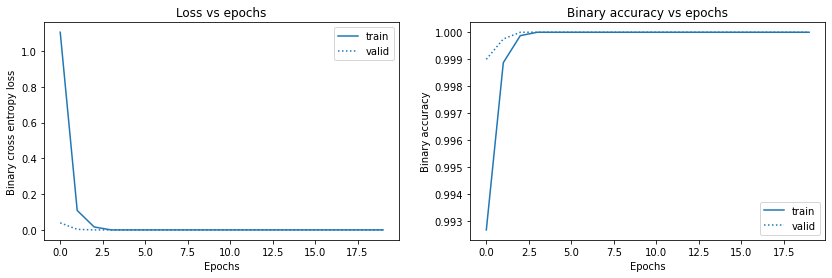

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()

# 1 Metbolite changed

"Creatinine"	0.5 	0.5

## Import data

In [51]:
import numpy as np

filename_control = '../data/Simulation_classification/Creat_0.5_0.5/Spectra_Mixt1.txt'
filename_case = '../data/Simulation_classification/Creat_0.5_0.5/Spectra_Mix2.txt'
data_control = np.loadtxt(filename_control, dtype=float)
data_case = np.loadtxt(filename_case, dtype=float)

In [52]:
#Convert into dataframes
import pandas as pd

df_control = pd.DataFrame(data_control).T
df_case = pd.DataFrame(data_case).T

#Concatenate control and case df
df_NMR_intensities = pd.concat([df_control, df_case])
df_status = [0] * df_control.shape[0] + [1] * df_case.shape[0]

## Shuffle the data

In [53]:
from sklearn.utils import shuffle

df_status, df_NMR_intensities = shuffle(df_status, df_NMR_intensities)

In [54]:
df_NMR_intensities.shape

(10000, 10000)

## Convert into tf.data

In [52]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_NMR_intensities, df_status))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [55]:
from tfrecords import write_tfrecords

In [56]:
write_tfrecords('../data/tfrecords/Classification/Creat_0.5_0.5', dataset=dataset, number=20)

## Read the tf.Record files

In [217]:
from tfrecords import read_tfrecords

In [218]:
file_paths = ['../data/tfrecords/Classification/Creat_0.5_0.5/data_{}.tfrecord'.format(i) for i in range(20)]
full_dataset = read_tfrecords(file_paths)

## Split data into train and validation datasets

In [219]:
from models import process_dataset

In [220]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[64] * 3, shuffle_buffers=10000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [221]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/sanity_check")

## Define simple MLP

In [222]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(10000,), hidden_units=[256, 256])
simple_model.summary()

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_117 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_118 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


## Compile model

In [223]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [224]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[earlystopping])

Epoch 1/20
125/125 [==============================] - 2s 19ms/step - loss: 8.2958 - binary_accuracy: 0.7916 - val_loss: 2.5258 - val_binary_accuracy: 0.6150
Epoch 2/20
125/125 [==============================] - 2s 18ms/step - loss: 1.4491 - binary_accuracy: 0.8085 - val_loss: 2.3323 - val_binary_accuracy: 0.8300
Epoch 3/20
125/125 [==============================] - 2s 18ms/step - loss: 0.9105 - binary_accuracy: 0.8275 - val_loss: 0.6595 - val_binary_accuracy: 0.8330
Epoch 4/20
125/125 [==============================] - 2s 18ms/step - loss: 0.6561 - binary_accuracy: 0.8332 - val_loss: 0.6310 - val_binary_accuracy: 0.8510
Epoch 5/20
125/125 [==============================] - 2s 18ms/step - loss: 0.5006 - binary_accuracy: 0.8415 - val_loss: 0.7150 - val_binary_accuracy: 0.8110
Epoch 6/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4087 - binary_accuracy: 0.8482 - val_loss: 0.4626 - val_binary_accuracy: 0.8580
Epoch 7/20
125/125 [==============================] - 2s 1

## Plot the learning curves

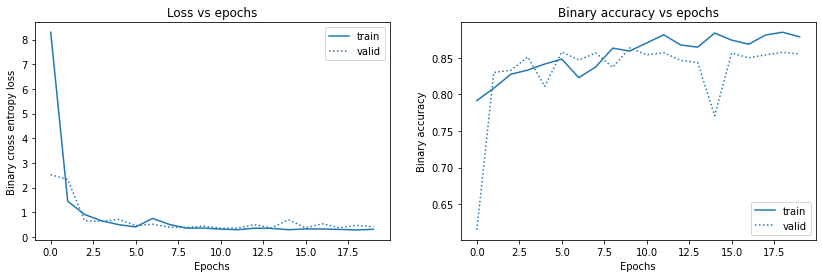

In [225]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'][:], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'][:], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()

In [226]:
print(simple_model.evaluate(val_dataset))

32/32 [==============================] - 0s 12ms/step - loss: 0.4168 - binary_accuracy: 0.8550
[0.4167819321155548, 0.8550000190734863]


## Try random forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_NMR_intensities, df_status, test_size=0.2, random_state=42)

clf = RandomForestClassifier(100, random_state=0, oob_score=True, max_features=700)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=700, oob_score=True, random_state=0)

In [56]:
print("Train accuracy :", clf.score(X_train, y_train))
print("Test accuracy :", clf.score(X_test, y_test))

Train accuracy : 1.0
Test accuracy : 0.866


# 1 Metbolite changed

"Creatinine"	0.25 	0.25

## Import data

In [126]:
import numpy as np

filename_control = '../data/Simulation_classification/Creat_0.25_0.25/Spectra_Mixt1.txt'
filename_case = '../data/Simulation_classification/Creat_0.25_0.25/Spectra_Mix2.txt'
data_control = np.loadtxt(filename_control, dtype=float)
data_case = np.loadtxt(filename_case, dtype=float)

In [127]:
#Convert into dataframes
import pandas as pd

df_control = pd.DataFrame(data_control).T
df_case = pd.DataFrame(data_case).T

#Concatenate control and case df
df_NMR_intensities = pd.concat([df_control, df_case])
df_status = [0] * df_control.shape[0] + [1] * df_case.shape[0]

## Shuffle the data

In [128]:
from sklearn.utils import shuffle

df_status, df_NMR_intensities = shuffle(df_status, df_NMR_intensities)

In [129]:
df_NMR_intensities.shape

(10000, 10000)

## Convert into tf.data

In [130]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_NMR_intensities, df_status))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [131]:
from tfrecords import write_tfrecords

In [132]:
write_tfrecords('../data/tfrecords/Classification/Creat_0.25_0.25', dataset=dataset, number=20)

## Read the tf.Record files

In [133]:
from tfrecords import read_tfrecords

In [138]:
file_paths = ['../data/tfrecords/Classification/Creat_0.25_0.25/data_{}.tfrecord'.format(i) for i in range(20)]
full_dataset = read_tfrecords(file_paths)

## Split data into train and validation datasets

In [139]:
from models import process_dataset

In [140]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[64] * 3, shuffle_buffers=10000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [141]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/sanity_check")

## Define simple MLP

In [171]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(10000,), hidden_units=[256, 256])
simple_model.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_108 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_109 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________


## Define regularized MLP

In [172]:
from models import get_regularised_bn_dropout_mlp

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp(input_shape=(10000,), hidden_units=[256, 256],
                                l2_reg_coeff=0.01, dropout_rate=0.5)
regularised_bn_dropout_model.summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_111 (Dense)            (None, 256)               2560256   
_________________________________________________________________
batch_normalization_65 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 256)               65792     
_________________________________________________________________
batch_normalization_66 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)             

## Compile simple model

In [173]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [174]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[earlystopping])

Epoch 1/100
7/7 [==============================] - 0s 33ms/step - loss: 79.8896 - binary_accuracy: 0.5925 - val_loss: 13.6537 - val_binary_accuracy: 0.9200
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 5.9206 - binary_accuracy: 0.9050 - val_loss: 3.8096 - val_binary_accuracy: 0.9500
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 2.8554 - binary_accuracy: 0.9725 - val_loss: 3.2245 - val_binary_accuracy: 0.9600
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 1.9538 - binary_accuracy: 0.9525 - val_loss: 2.7107 - val_binary_accuracy: 0.9700
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 2.1808 - binary_accuracy: 0.9500 - val_loss: 2.1749 - val_binary_accuracy: 0.9800
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 1.8318 - binary_accuracy: 0.9700 - val_loss: 3.2926 - val_binary_accuracy: 0.8300
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 1.

7/7 [==============================] - 0s 20ms/step - loss: 7.8934e-07 - binary_accuracy: 1.0000 - val_loss: 1.0780 - val_binary_accuracy: 0.9700
Epoch 54/100
7/7 [==============================] - 0s 21ms/step - loss: 7.7505e-07 - binary_accuracy: 1.0000 - val_loss: 1.0773 - val_binary_accuracy: 0.9700
Epoch 55/100
7/7 [==============================] - 0s 20ms/step - loss: 7.4943e-07 - binary_accuracy: 1.0000 - val_loss: 1.0767 - val_binary_accuracy: 0.9700
Epoch 56/100
7/7 [==============================] - 0s 20ms/step - loss: 7.2836e-07 - binary_accuracy: 1.0000 - val_loss: 1.0761 - val_binary_accuracy: 0.9700
Epoch 57/100
7/7 [==============================] - 0s 20ms/step - loss: 7.1251e-07 - binary_accuracy: 1.0000 - val_loss: 1.0755 - val_binary_accuracy: 0.9700
Epoch 58/100
7/7 [==============================] - 0s 20ms/step - loss: 6.9097e-07 - binary_accuracy: 1.0000 - val_loss: 1.0749 - val_binary_accuracy: 0.9700
Epoch 59/100
7/7 [==============================] - 0s 20ms

## Plot the learning curves

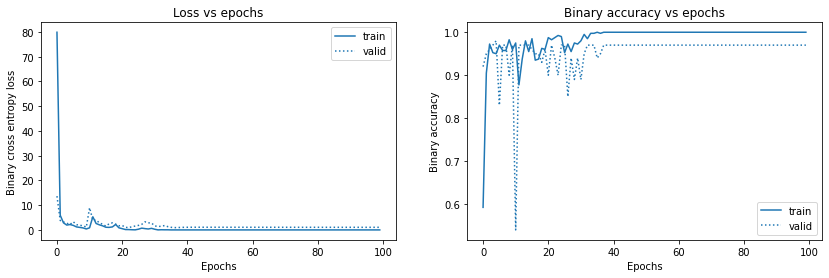

In [175]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'][:], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'][:], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()

In [211]:
print(simple_model.evaluate(val_dataset))

2/2 [==============================] - 0s 7ms/step - loss: 1.0531 - binary_accuracy: 0.9700
[1.0531206130981445, 0.9700000286102295]


## Compile regularized model

In [176]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [177]:
regularised_bn_dropout_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = regularised_bn_dropout_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[earlystopping])

Epoch 1/1000
7/7 [==============================] - 0s 37ms/step - loss: 7.3342 - binary_accuracy: 0.8600 - val_loss: 8.1620 - val_binary_accuracy: 0.6700
Epoch 2/1000
7/7 [==============================] - 0s 25ms/step - loss: 5.7745 - binary_accuracy: 0.9525 - val_loss: 6.9694 - val_binary_accuracy: 0.6100
Epoch 3/1000
7/7 [==============================] - 0s 21ms/step - loss: 4.6428 - binary_accuracy: 0.9525 - val_loss: 5.6317 - val_binary_accuracy: 0.6100
Epoch 4/1000
7/7 [==============================] - 0s 22ms/step - loss: 3.8735 - binary_accuracy: 0.9425 - val_loss: 4.1956 - val_binary_accuracy: 0.7300
Epoch 5/1000
7/7 [==============================] - 0s 23ms/step - loss: 3.2326 - binary_accuracy: 0.9675 - val_loss: 3.1770 - val_binary_accuracy: 0.8700
Epoch 6/1000
7/7 [==============================] - 0s 24ms/step - loss: 2.8345 - binary_accuracy: 0.9725 - val_loss: 2.7274 - val_binary_accuracy: 0.9700
Epoch 7/1000
7/7 [==============================] - 0s 24ms/step - los

7/7 [==============================] - 0s 23ms/step - loss: 0.4845 - binary_accuracy: 0.9650 - val_loss: 0.5103 - val_binary_accuracy: 0.9800
Epoch 54/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.4613 - binary_accuracy: 0.9825 - val_loss: 0.4858 - val_binary_accuracy: 0.9800
Epoch 55/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.4725 - binary_accuracy: 0.9625 - val_loss: 0.4772 - val_binary_accuracy: 0.9700
Epoch 56/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.4341 - binary_accuracy: 0.9775 - val_loss: 0.4722 - val_binary_accuracy: 0.9700
Epoch 57/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.4358 - binary_accuracy: 0.9750 - val_loss: 0.4640 - val_binary_accuracy: 0.9700
Epoch 58/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.4191 - binary_accuracy: 0.9675 - val_loss: 0.4773 - val_binary_accuracy: 0.9500
Epoch 59/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.40

7/7 [==============================] - 0s 24ms/step - loss: 0.2087 - binary_accuracy: 0.9775 - val_loss: 0.2830 - val_binary_accuracy: 0.9500
Epoch 106/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.2156 - binary_accuracy: 0.9775 - val_loss: 0.2889 - val_binary_accuracy: 0.9500
Epoch 107/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.2017 - binary_accuracy: 0.9725 - val_loss: 0.2654 - val_binary_accuracy: 0.9700
Epoch 108/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.1973 - binary_accuracy: 0.9750 - val_loss: 0.2683 - val_binary_accuracy: 0.9700
Epoch 109/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.2258 - binary_accuracy: 0.9625 - val_loss: 0.2589 - val_binary_accuracy: 0.9700
Epoch 110/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.2171 - binary_accuracy: 0.9675 - val_loss: 0.3236 - val_binary_accuracy: 0.9400
Epoch 111/1000
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.1724 - binary_accuracy: 0.9725 - val_loss: 0.2433 - val_binary_accuracy: 0.9500
Epoch 158/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1935 - binary_accuracy: 0.9725 - val_loss: 0.2366 - val_binary_accuracy: 0.9500
Epoch 159/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1767 - binary_accuracy: 0.9700 - val_loss: 0.2431 - val_binary_accuracy: 0.9500
Epoch 160/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.2019 - binary_accuracy: 0.9675 - val_loss: 0.3114 - val_binary_accuracy: 0.9000
Epoch 161/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1644 - binary_accuracy: 0.9825 - val_loss: 0.3015 - val_binary_accuracy: 0.9000
Epoch 162/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1733 - binary_accuracy: 0.9725 - val_loss: 0.3727 - val_binary_accuracy: 0.8900
Epoch 163/1000
7/7 [==============================] - 0s 22ms/step - loss

7/7 [==============================] - 0s 22ms/step - loss: 0.1554 - binary_accuracy: 0.9725 - val_loss: 0.4827 - val_binary_accuracy: 0.9100
Epoch 210/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1629 - binary_accuracy: 0.9800 - val_loss: 0.2995 - val_binary_accuracy: 0.9400
Epoch 211/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1602 - binary_accuracy: 0.9800 - val_loss: 0.2261 - val_binary_accuracy: 0.9500
Epoch 212/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1389 - binary_accuracy: 0.9825 - val_loss: 0.2356 - val_binary_accuracy: 0.9500
Epoch 213/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1621 - binary_accuracy: 0.9700 - val_loss: 0.2196 - val_binary_accuracy: 0.9600
Epoch 214/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1556 - binary_accuracy: 0.9775 - val_loss: 0.2743 - val_binary_accuracy: 0.9500
Epoch 215/1000
7/7 [==============================] - 0s 22ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.1645 - binary_accuracy: 0.9725 - val_loss: 0.2041 - val_binary_accuracy: 0.9700
Epoch 262/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1676 - binary_accuracy: 0.9700 - val_loss: 0.1964 - val_binary_accuracy: 0.9700
Epoch 263/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1772 - binary_accuracy: 0.9650 - val_loss: 0.1930 - val_binary_accuracy: 0.9700
Epoch 264/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1560 - binary_accuracy: 0.9775 - val_loss: 0.1914 - val_binary_accuracy: 0.9800
Epoch 265/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1522 - binary_accuracy: 0.9725 - val_loss: 0.1844 - val_binary_accuracy: 0.9700
Epoch 266/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1582 - binary_accuracy: 0.9750 - val_loss: 0.1693 - val_binary_accuracy: 0.9800
Epoch 267/1000
7/7 [==============================] - 0s 25ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.1549 - binary_accuracy: 0.9750 - val_loss: 0.2012 - val_binary_accuracy: 0.9500
Epoch 314/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1618 - binary_accuracy: 0.9725 - val_loss: 0.1745 - val_binary_accuracy: 0.9700
Epoch 315/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1463 - binary_accuracy: 0.9800 - val_loss: 0.1742 - val_binary_accuracy: 0.9700
Epoch 316/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1509 - binary_accuracy: 0.9750 - val_loss: 0.1763 - val_binary_accuracy: 0.9800
Epoch 317/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1414 - binary_accuracy: 0.9800 - val_loss: 0.1829 - val_binary_accuracy: 0.9700
Epoch 318/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1452 - binary_accuracy: 0.9775 - val_loss: 0.1819 - val_binary_accuracy: 0.9700
Epoch 319/1000
7/7 [==============================] - 0s 22ms/step - loss

7/7 [==============================] - 0s 22ms/step - loss: 0.1458 - binary_accuracy: 0.9725 - val_loss: 0.1729 - val_binary_accuracy: 0.9800
Epoch 366/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1558 - binary_accuracy: 0.9700 - val_loss: 0.1747 - val_binary_accuracy: 0.9800
Epoch 367/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.1393 - binary_accuracy: 0.9800 - val_loss: 0.1812 - val_binary_accuracy: 0.9700
Epoch 368/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1254 - binary_accuracy: 0.9800 - val_loss: 0.1798 - val_binary_accuracy: 0.9700
Epoch 369/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1477 - binary_accuracy: 0.9800 - val_loss: 0.9085 - val_binary_accuracy: 0.8900
Epoch 370/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.1700 - binary_accuracy: 0.9625 - val_loss: 0.4254 - val_binary_accuracy: 0.8200
Epoch 371/1000
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 22ms/step - loss: 0.1616 - binary_accuracy: 0.9700 - val_loss: 0.1812 - val_binary_accuracy: 0.9600
Epoch 418/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1435 - binary_accuracy: 0.9750 - val_loss: 0.1734 - val_binary_accuracy: 0.9800
Epoch 419/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1515 - binary_accuracy: 0.9675 - val_loss: 0.1822 - val_binary_accuracy: 0.9700
Epoch 420/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1720 - binary_accuracy: 0.9675 - val_loss: 0.2214 - val_binary_accuracy: 0.9500
Epoch 421/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1499 - binary_accuracy: 0.9725 - val_loss: 0.2219 - val_binary_accuracy: 0.9500
Epoch 422/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1441 - binary_accuracy: 0.9800 - val_loss: 0.1954 - val_binary_accuracy: 0.9500
Epoch 423/1000
7/7 [==============================] - 0s 22ms/step - loss

7/7 [==============================] - 0s 24ms/step - loss: 0.1773 - binary_accuracy: 0.9575 - val_loss: 1.0942 - val_binary_accuracy: 0.5600
Epoch 470/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1831 - binary_accuracy: 0.9650 - val_loss: 0.3462 - val_binary_accuracy: 0.8600
Epoch 471/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1475 - binary_accuracy: 0.9675 - val_loss: 0.1876 - val_binary_accuracy: 0.9600
Epoch 472/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1392 - binary_accuracy: 0.9675 - val_loss: 0.1840 - val_binary_accuracy: 0.9600
Epoch 473/1000
7/7 [==============================] - 0s 27ms/step - loss: 0.1397 - binary_accuracy: 0.9800 - val_loss: 0.1763 - val_binary_accuracy: 0.9700
Epoch 474/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1541 - binary_accuracy: 0.9700 - val_loss: 0.1850 - val_binary_accuracy: 0.9600
Epoch 475/1000
7/7 [==============================] - 0s 24ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.1164 - binary_accuracy: 0.9700 - val_loss: 0.1605 - val_binary_accuracy: 0.9800
Epoch 522/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1255 - binary_accuracy: 0.9750 - val_loss: 0.2193 - val_binary_accuracy: 0.9300
Epoch 523/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1184 - binary_accuracy: 0.9875 - val_loss: 0.2588 - val_binary_accuracy: 0.9000
Epoch 524/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1299 - binary_accuracy: 0.9750 - val_loss: 0.1726 - val_binary_accuracy: 0.9700
Epoch 525/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1321 - binary_accuracy: 0.9750 - val_loss: 0.1738 - val_binary_accuracy: 0.9700
Epoch 526/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1199 - binary_accuracy: 0.9850 - val_loss: 0.1730 - val_binary_accuracy: 0.9600
Epoch 527/1000
7/7 [==============================] - 0s 22ms/step - loss

7/7 [==============================] - 0s 26ms/step - loss: 0.1741 - binary_accuracy: 0.9650 - val_loss: 0.2012 - val_binary_accuracy: 0.9600
Epoch 574/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.1579 - binary_accuracy: 0.9650 - val_loss: 0.1967 - val_binary_accuracy: 0.9700
Epoch 575/1000
7/7 [==============================] - 0s 26ms/step - loss: 0.1458 - binary_accuracy: 0.9775 - val_loss: 0.2016 - val_binary_accuracy: 0.9700
Epoch 576/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1586 - binary_accuracy: 0.9700 - val_loss: 0.2008 - val_binary_accuracy: 0.9600
Epoch 577/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1534 - binary_accuracy: 0.9675 - val_loss: 0.2078 - val_binary_accuracy: 0.9600
Epoch 578/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1249 - binary_accuracy: 0.9825 - val_loss: 0.2152 - val_binary_accuracy: 0.9500
Epoch 579/1000
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 22ms/step - loss: 0.1270 - binary_accuracy: 0.9825 - val_loss: 2.1221 - val_binary_accuracy: 0.4400
Epoch 626/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1485 - binary_accuracy: 0.9725 - val_loss: 0.2591 - val_binary_accuracy: 0.9300
Epoch 627/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1509 - binary_accuracy: 0.9675 - val_loss: 0.1808 - val_binary_accuracy: 0.9800
Epoch 628/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1286 - binary_accuracy: 0.9825 - val_loss: 0.1801 - val_binary_accuracy: 0.9600
Epoch 629/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.1414 - binary_accuracy: 0.9825 - val_loss: 0.2422 - val_binary_accuracy: 0.9300
Epoch 630/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1454 - binary_accuracy: 0.9700 - val_loss: 0.2550 - val_binary_accuracy: 0.9300
Epoch 631/1000
7/7 [==============================] - 0s 22ms/step - loss

## Plot the learning curves

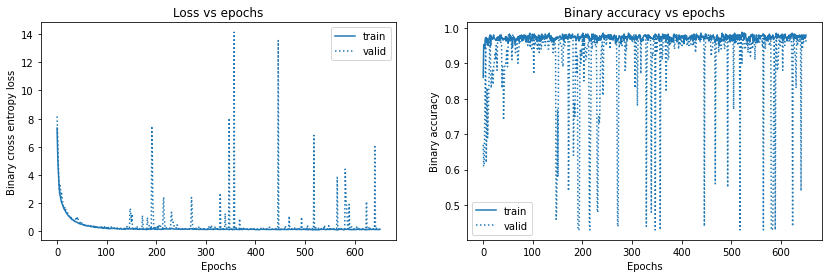

In [181]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()

In [182]:
print(regularised_bn_dropout_model.evaluate(val_dataset))

2/2 [==============================] - 0s 8ms/step - loss: 0.1861 - binary_accuracy: 0.9600
[0.18611295521259308, 0.9599999785423279]


## Try random forest

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_NMR_intensities, df_status, test_size=0.2, random_state=42)

clf = RandomForestClassifier(100, random_state=0, oob_score=True, max_features=700)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=700, oob_score=True, random_state=0)

In [186]:
print("Train accuracy :", clf.score(X_train, y_train))
print("Test accuracy :", clf.score(X_test, y_test))

Train accuracy : 1.0
Test accuracy : 0.9775


In [321]:
mu = 13200
sigma = 4100
alpha = 0.5

normal_creat = np.random.normal(loc=mu, scale=sigma, size=5000)
poisoned_creat = np.random.normal(loc=mu*alpha, scale=sigma*alpha, size=5000)

In [322]:
def delta(mu, sigma, alpha):
    return ((4*mu**2*(1-alpha)**2) - (8*sigma**2*np.log(alpha)*(1-alpha**2)))/alpha**2

def border(mu, sigma, alpha):
    return ((2*mu*(1 - alpha)/alpha) + (delta(mu, sigma, alpha)**0.5))/(2*(1-alpha**2)/alpha**2)

border = border(mu, sigma, alpha)
print(border)

9608.44212826399


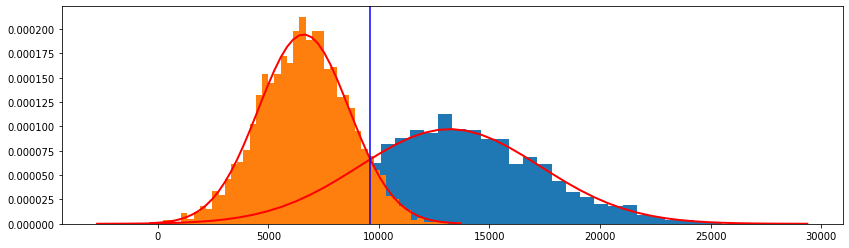

In [323]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

count, bins, ignored = plt.hist(normal_creat, 50, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
count, bins, ignored = plt.hist(poisoned_creat, 50, density=True)
plt.plot(bins, 1/(alpha*sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - alpha*mu)**2 / (2 * (alpha*sigma)**2) ),
         linewidth=2, color='r')
plt.axvline(x = border, color = 'b', linestyle = '-')
plt.show()

In [324]:
from scipy.stats import norm
TN = 1 - norm.cdf(border, mu, sigma)
TP = norm.cdf(border, alpha*mu, alpha*sigma)
Acc = (TP + TN)/2
print(Acc)

0.8691832980171983
